Theres a back bone and a classifier:
The backbone has a number of blocks and each block has
 - A linear/MLP layer predicitng a vector a with k elements from an input tensor X.
  - a = g(SpatialAveragePool(X)W) where g is a non linear activation function
  SpatialAveragePool(X) calculates the spatial average per channel returning a vector of d channels
- K convolution layers which are combines using a to produce a single output: o= a1Conva(X)+ ... + akConvK(X)

The classifier:
- Takes the output of the last block as an input
- Comptes mean feature f = SpatialAveragePool(On), where On is the output of the Nth block
- It passes f to a classifier
 - Can be softmax regression or an MLP


In [1]:
#IMPORTS
import torch
import torch.nn as nn
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as f
import torch.optim as optim
import matplotlib.pyplot as plt

I was going to use the unpickle function until I found out that pytorch has Cifar10 dataset already? At that time I had alot of errors and my network was not learning so I switched to using torchvision datasets in case there was an issue with me loading my data.

In [2]:
#RETURN CIFAR10 DATASET AS DICT
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Create CIFAR-10 training and testing datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create training and testing dataloaders
batch_size = 256
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
So weights would be 1024x10 and the biases would be 10x1

In [4]:
#MODEL.... EEEK EEEK
class block(nn.Module):
   def __init__(self, in_channels, out_channels, convLayers):
        super(block, self).__init__()
        self.linear = nn.Linear(in_channels, convLayers)
        # Multiple convolutional layers
        self.convs = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) for _ in range(convLayers)]) 
        self.spatavgpool = nn.AdaptiveAvgPool2d((1,1))
        

   def forward(self, x):
    avg_pool = self.spatavgpool(x)
    avg_pool = avg_pool.view(avg_pool.size(0), -1)
    a = self.linear(avg_pool)
    # Non linear activation function
    a = f.relu(a)
    conv_outputs = []
    for i, conv in enumerate(self.convs):
        coeff = a[:, i].view(-1, 1, 1, 1)
        conv_output = conv(x) * coeff
        conv_outputs.append(conv_output)
    out = sum(conv_outputs)
    return out


class classifier(nn.Module):
   def __init__(self, inputs, outputs):
        super(classifier, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # SpatialAveragePool
        # Im using a stack of linear layers whilst having the relu inbetween each, I go up to 1024 neurons before going down to 10.
        # Theres a dropout here too because my model kept overfitting so I included that to prevent this.
        self.fc = nn.Sequential(nn.Linear(inputs,1024),
                                nn.ReLU(), 
                                nn.Dropout(p=0.5), 
                                nn.Linear(1024, 512), 
                                nn.ReLU(),
                                nn.Dropout(p=0.5), 
                                nn.Linear(512, 256), 
                                nn.ReLU(), nn.Dropout(p=0.5),nn.Linear(256,10))

   def forward(self,x):
       x = self.avg_pool(x)
       x = x.view(x.size(0), -1)
       # Pass the mean feature to the MLP
       x = self.fc(x)
       return x


class model(nn.Module):
  def __init__(self, in_channels, out_channels, convLayers, num_classes):
    super(model, self).__init__()
    # The model has three blocks wich spit out 256 output channels that goes to the classifier
    self.blocks = nn.ModuleList([block(in_channels,out_channels, convLayers), block(out_channels, 128, convLayers), block(128, 256, convLayers), nn.ReLU()])
    self.classifier = classifier(256, num_classes)

  def forward(self,x):
    # The output of the last block goes into the classifier
    for block in self.blocks:
      x = block(x)
    x = self.classifier(x)
    return x


The model above is split into three parts, the first is the block that takes in number of input channels, output channels and convolutional layers. The block then creates the specified amount of convolutional layers, creates an linear layer and a spatial average pool. After doing a linear layer using the average pool and using a non linear activation function on the result, the block then does element wise multiplication on the convolutional layer and the coefficient (comes from the linear layer)

The classifier takes in inputs, (takes in outputs too but that isnt being used, dont know why I still havent gotten rid of that...) and creates a spatial average pool and three linear layers with dropouts and relu's inbetween. It then does the spatial average pool and send it to the multi layer perceptron. I believe I actually used softmax regression first and then switched to an MLP, I got better results with the MLP than the softmax regression classifier.

Finally the model creates a classifier and three blocks, and the for every block it produces an output of which that output is then sent to the classifier and returned.

In [5]:
#LOSS AND OPTIMISATION FUNCTION
in_channels = 3  # RGB input
out_channels = 64
convLayers = 4
num_classes = 10  # Number of classes in CIFAR-10
model = model(in_channels, out_channels, convLayers, num_classes)

# Define the loss criterion and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr= 0.001)

In [6]:
from IPython.display import clear_output
def Accuracygraph(train_accuracies, test_accuracies):
    clear_output(wait=True)
    plt.plot(train_accuracies, label='training accuracy')
    plt.plot(test_accuracies, label='testing accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training vs Testing accuracy')
    plt.ylim(1, 100)  # Set y-axis range from 1 to 100
    plt.grid(True)
    plt.show()
    
def Lossgraph(train_loss, test_loss):
    clear_output(wait=True)
    plt.plot(train_loss, label='training loss')
    plt.plot(test_loss, label='testing loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Testing loss')
    plt.ylim(0, 3)  # Set y-axis range from 0 to 3
    plt.xlim(-10, 60)
    plt.grid(True)
    plt.show()

The above is my graph plotting functions

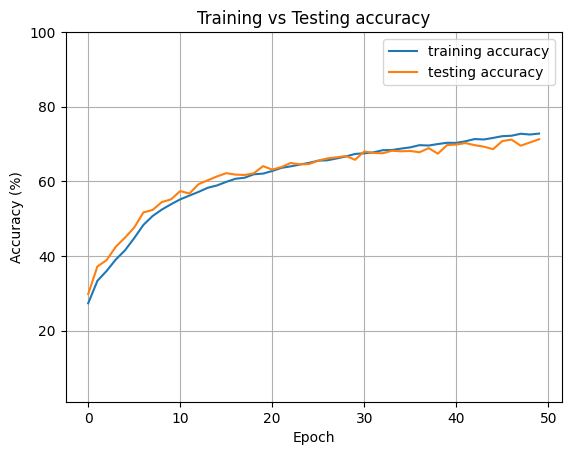

In [8]:
#TRAINING
num_of_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
total_step = len(train_loader)

model = model.to(device)
criterion = criterion.to(device)

train_losses = []
test_losses = []
train_accuracies = [] 
test_accuracies = []
train_loss = 0
test_loss = 0

for epoch in range(num_of_epochs):
    correct_train = 0
    total_train = 0
    correct_test = 0
    total_test = 0
    
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward and optimize
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        
        train_accuracy = 100 * correct_train / total_train
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch+1, num_of_epochs, i+1, total_step, loss.item(), train_accuracy))
    
    #Calculate training accuracy and losses
    accuracy = 100 * correct_train / total_train
    train_loss = train_loss/i
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)
    
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_losses.append(test_loss)
            
            test_accuracy = 100 * (correct_test/total_test)
            print('Testing Loss: {:.4f}, Testing Accuracy: {:.2f}%'.format(loss.item(), test_accuracy))

    # Calculate testing accuracy
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)
    
    Accuracygraph(train_accuracies, test_accuracies)
    




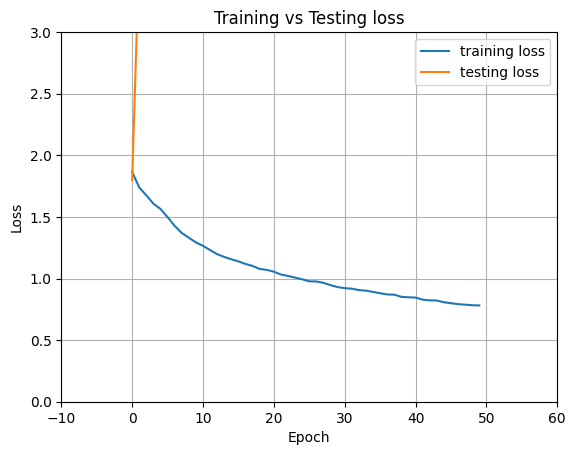

[27.364, 33.386, 36.03, 39.09, 41.558, 44.826, 48.364, 50.746, 52.462, 53.894, 55.208, 56.216, 57.212, 58.314, 58.934, 59.882, 60.72, 60.998, 61.922, 62.104, 62.8, 63.644, 64.044, 64.532, 64.976, 65.57, 65.672, 66.16, 66.698, 67.37, 67.548, 67.79, 68.37, 68.422, 68.804, 69.126, 69.722, 69.626, 70.02, 70.36, 70.33, 70.766, 71.356, 71.248, 71.66, 72.128, 72.244, 72.776, 72.57, 72.826]
[29.83, 37.24, 38.93, 42.52, 44.96, 47.66, 51.71, 52.37, 54.48, 55.2, 57.43, 56.77, 59.29, 60.32, 61.35, 62.22, 61.84, 61.73, 62.2, 64.1, 63.18, 63.85, 64.95, 64.58, 64.66, 65.57, 66.18, 66.47, 66.81, 65.81, 68.04, 67.63, 67.55, 68.22, 68.08, 68.17, 67.81, 68.93, 67.44, 69.74, 69.89, 70.28, 69.72, 69.31, 68.66, 70.82, 71.21, 69.58, 70.44, 71.31]
[1.7982121706008911, 3.651959180831909, 5.586980819702148, 7.386143922805786, 9.39538025856018, 11.285196423530579, 13.165103673934937, 15.101611614227295, 16.988967180252075, 18.90576434135437, 20.805459022521973, 22.65031623840332, 24.52209186553955, 26.3732244968

In [9]:
Lossgraph(train_losses, test_losses)
print(train_accuracies)
print(test_accuracies)
print(test_losses)
print(train_losses)